# Эффективные алгоритмы для SVMs

В этой задаче мы будем решать задачу SVM.
Для того, чтобы осознать, что это актуально и активно исследуется, можно посмотреть например на эту статью:
https://papers.nips.cc/paper/8856-unixgrad-a-universal-adaptive-algorithm-with-optimal-guarantees-for-constrained-optimization.pdf
Это статья с NeurIPS (ТОП-1 конференции по машинному обучению) от Френсиса Баха (одного из самых цитируемых людей в оптимизации для ML).

Если Вы не знаете, что такое SVM и как он работает, можно посмотреть, например тут:
https://habr.com/ru/company/ods/blog/484148/
и в ссылках к этой статье.

Нас интересует решение задачи:
$$
\min_{w \in R^n, \zeta \in R^k, b \in R}\frac{1}{2}\|w\|_2^2 + \alpha \sum_{i=1}^k \zeta_i \\
y^{(i)} (w^Tx^{(i)} - b) \geq 1-\zeta_i \quad \forall 1\leq i\leq k\\
\zeta_i \geq 0 \quad \forall 1 \leq i \leq k
$$

Если простыми словами, то у нас есть $k$ точек $(x^{(i)}, y^{(i)})$ ($1 \leq i \leq k$) в пространстве $R^n \times R$.  Соответственно, индекс $i$ - Это просто "номер" точки. Здесь $x$ отвечает за признаки, а $y \in {-1, 1}$ - лейблы (метки), которые указывают на "класс" точки (соответственно, для точек из одного класса $y=1$, а для другого $y=-1$).

SVM пытается используя информацию о заданных $k$ точках построить правило, которое делило бы все точки пространства на два класса. При этом здесь предполагается, что точки на два класса можно разделить с помощью гиперплоскости. Как Вы знаете, гиперплоскость задается двумя параметрами: вектором (в этой задаче $w \in R^n$) и константой (здесь $b \in R$).

Их мы и пытаемся найти в этой задаче.

Если бы наша выборка была бы линейно разделима (то есть существует гиперплоскость, такая, что точки из разных классов лежат по разные стороны гиперплоскости), то $\zeta=0$. Но не всегда точки разделимы (например, из-за шума). Поэтому мы написали SVM с мягкими ограничениями, то есть просто штрафуя за нарушения (то есть за попадание точки одного класса на часть пространства, которая относится к другому классу) пропорционально нарушению.

Ок, с объяснением задачи закончили.
Теперь про методы...


Вы изучили достаточно много методов для решения таких задач:


*   Реализуйте метод проксимального градиентного спуска для этой задачи (3 балла)
*   Реализуйте метод ADMM для этой задачи (3 балла)


*   Реализуйте быстрый градиентный спуск используя метод сглаживания (5 баллов)
*   Реализуйте метод субградиентного спуска для этой задачи (3 балла)


*   Представьте эту задачу в виде, для которого можно использовать метод условного градиента или метод проекции градиента. Реализуйте их (3 балла).




*   Проведите расчеты для данных breast-cancer (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html) (3 балла)
*   Сравните скорость сходимости методов для этого инстанса задачи (то есть конкретно для этого набора данных) (2 балла)


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
l = 683 #количество объектов 
n = 10 #количество признаков

In [3]:
y = np.zeros((l,))
X = np.zeros((l, n))

In [4]:
f = open('task.txt', 'r')
for i, line in enumerate(f):
    line = line.split(' ')
    for c in line:
        if c == '4':
            y[i] = 1
        elif c == '2':
            y[i] = -1
        elif c == '\n':
            continue
        else:
            c = c.split(':')
            X[i][int(c[0]) - 1] = float(c[1])

# Быстрый градиентый спуск с использованием сглаживания

Запишем задачу, используя технику сглаживания:
$$f_{\mu}(w) = \frac{1}{2}\|w\|^2_2 + \max\limits_{0\leq \textbf{u} \leq 1}\left[\alpha\sum\limits_{i=1}^{\ell}u_i\left(1-y_i(w^Tx_i-w_0)\right) - \frac{\mu}{2}\|u\|^2_2\right].$$

Найдем явный $f_{\mu}(w)$. Условие оптимальности по $u_i$. Лагранжиан имеет вид:

$$L(w, \lambda, \nu) = \frac{\mu}{2}\|u\|^2_2 - \alpha\sum\limits_{i=1}^{\ell}u_i\left(1-y_i(w^Tx_i-w_0)\right) - \sum\limits_{i=1}^{\ell}\lambda_i u_i + \sum\limits_{i=1}^{\ell}\nu_i (u_i-1).$$

Условие оптимальности по $u_i$:

$$L_{u_i} = \mu u_i - \alpha(1-y_i(w^Tx_i-w_0) -\lambda_i + \nu_i = 0 \Rightarrow u_i = \frac{\alpha(1-y_i(w^Tx_i-w_0) + \lambda_i - \nu_i}{\mu}.$$

Учтем, что должно выполняться $u_i\lambda_i = 0, \nu_i(u_i-1) = 0$, а также, что $0 \geq u_i \geq 1$. Тогда получаем оптимальное значение $u_i$:

$$u_i = \begin{cases}1, \qquad \qquad\qquad \alpha(1-y_i(w^Tx_i-w_0) > \mu\\
\frac{\alpha(1-y_i(w^Tx_i-w_0)}{\mu}, ~~~~~~~\alpha(1-y_i(w^Tx_i-w_0) \in [0, \mu]\\
0, \qquad \qquad\qquad\alpha(1-y_i(w^Tx_i-w_0) < 0\end{cases}$$

Тогда $f_{\mu} = \frac{1}{2}\|w\|_2^2 + \alpha\sum\limits_{i=1}^{\ell}(u_{opt})i\left(1-y_i(w^Tx_i-w_0)\right) - \frac{\mu}{2}\|u_{opt}\|^2_2.$ Отсюда получаем, что

$$\nabla_{w} f_{\mu} = w -\alpha \sum\limits_{i=1}^{\ell} u_iy_i x_i,\qquad \nabla_{w_0} f_{\mu} = \alpha\sum\limits_{i=1}^{\ell}u_iy_i. $$

Выпишем шаги быстрого градиентного спуска:

- $Compute~\hat{F}(w_k)~and~\nabla \hat{F}(w_k)$

- $Find~z_k = T_Q(w_k) = \text{argmin}_{z}\left[\nabla^T f_{\mu}(w_k)(z-w_k)+\frac{L}{2}||z-w_k||_2^2\right].$

Найдем, как вычислять оптимальное $z$. Приравняем градиент по $z$  к нулю

$$\nabla f_{\mu}(w_k) + L(z - w_k) = 0 \Rightarrow z_k = w_k - \frac{1}{L}\nabla f_{\mu}(w_k). $$


- $Find~r_k = \text{argmin}_r\left[\frac{L}{\sigma_2}d(r) +  \sum\limits_{i=0}^k\alpha_i\left(f_{\mu}(w_i) + \nabla^Tf_{\mu}(w_i)(r-w_i)\right)\right] = \text{argmin}_r \left[\frac{L}{2}||r||_2^2 + \sum\limits_{i=0}^k\frac{i+1}{2}\left(f_{\mu}(w_i) + \nabla^T f_{\mu}(w_i)(r-w_i)\right)\right].$

Приравняем градиент по $r$ нулю:
$$Lr + \sum\limits_{i=1}^k \frac{i+1}{2} \nabla\hat{F}(w_i) = 0 \Rightarrow r_k = - \frac{1}{L}\sum\limits_{i=1}^k \frac{i+1}{2} \nabla f_{\mu}(w_i).$$

- $Set~w_{k+1} = \frac{2}{k+3} r_k + \frac{k+1}{k+3}z_k.$

In [7]:
alp = 1
mu = 1
Lip = 100000

In [8]:
def grad_f(w, u):
    ans = np.zeros(n+1)
    for k in range(n):
        ans[k] = w[k]
        for i, x_i in enumerate(X):
            ans[k] -= alp*y[i]*u[i]*x_i[k]
    for i in range(l):
        ans[n] += alp*u[i]*y[i]
    return ans


def opt_u(w):
    ans = np.zeros(l)
    v = w[:-1]
    v_0 = w[-1]
    for i, x_i in enumerate(X):
        temp = alp*(1-y[i]*(v.dot(x_i) - v_0))
        if (temp > mu):
            ans[i] = 1
        elif (temp < 0):
            ans[i] = 0
        else:
            ans[i] = temp/mu
    return ans

def L(w):
    v=w[:-1]
    v_0 = w[-1]
    ans = 1/2*np.linalg.norm(v)**2
    for i, x_i in enumerate(X):
        if (1 - y[i]*v.T.dot(x_i) + y[i]*v_0 >= 0):
            ans += alp*(1 - y[i]*v.T.dot(x_i) + y[i]*v_0)
    return ans

def predict(x):
    for i in range(len(x)):
        if x[i] >= 0:
            x[i] = 1
        else:
            x[i] = -1
    return x

In [10]:
z_opt = np.zeros(n+1)
r_opt = np.zeros(n+1)
func_smooth = []
accuracy_smooth = []
w = np.zeros(n+1)
w[-1] = 0
u_opt = opt_u(w)
eps = L(w)
k=0
for i in range(200):
    gradient = grad_f(w, u_opt)
    z_opt = w - gradient/Lip
    r_opt = r_opt - float((k+1))*gradient/(2*Lip)
    w = 2*r_opt/(i+3) + (i+1)*z_opt/(i+3)
    u_opt = opt_u(w)
    k+=1
    eps = L(w)
    func_smooth.append(eps)
    a = accuracy_score(y, predict(X.dot(w[:-1])-w[-1]))
    accuracy_smooth.append(a)
    print(a, eps)

0.8433382137628112 672.5147499211931
0.8433382137628112 658.4744940999522
0.8448023426061494 641.1824144982634
0.8448023426061494 620.9897877808015
0.8448023426061494 598.2867717070976
0.8462664714494875 573.4925813356921
0.8462664714494875 547.0453269178222
0.849194729136164 519.3917872129861
0.849194729136164 490.97737851221495
0.8535871156661786 462.2365694321285
0.8565153733528551 433.5839756486948
0.8609077598828697 405.40632012749705
0.8609077598828697 378.0554483525556
0.8682284040995608 351.84253231649467
0.8755490483162518 327.0334751140604
0.87701317715959 303.8456947267572
0.8828696925329429 282.4462980823026
0.8857979502196194 262.98410804744026
0.8857979502196194 246.47039941792875
0.8931185944363104 233.42596829439245
0.8975109809663251 222.98101322007503
0.9121522693997072 214.49388073961575
0.9194729136163983 207.0007447173267
0.9224011713030746 200.4800809841457
0.9282576866764275 194.50567403245546
0.931185944363104 188.9562865663228
0.9326500732064422 183.69021673437

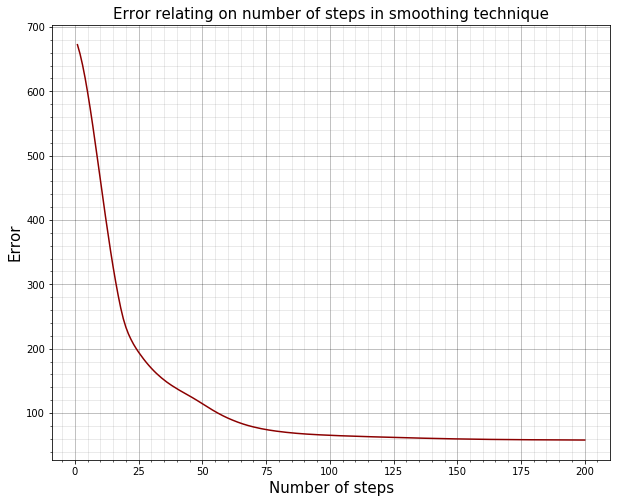

In [11]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(func_smooth)), func_smooth, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Error relating on number of steps in smoothing technique', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

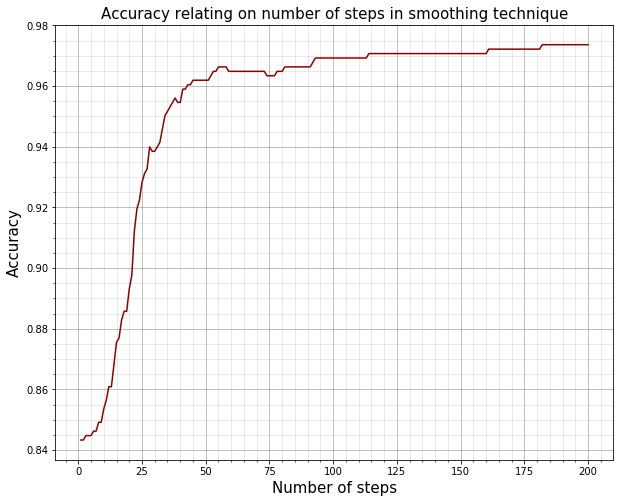

In [12]:
plt.figure(figsize=[10, 8])
plt.plot(range(1, 1+len(accuracy_smooth)), accuracy_smooth, color='darkred')
plt.xlabel('Number of steps', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy relating on number of steps in smoothing technique', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.show()

# Эффективные алгоритмы для вспомагательных задач бинарной классификации

Решается задача бинарной классификации.
Для этого используется классификатор на базе l1-регуляризованной логистической регрессии. 
Про все это можно прочитать, например, тут:
https://habr.com/ru/company/ods/blog/323890/#lineynyy-klassifikator

Чтобы "обучить" модель нужно решить задачу оптимизации:
$$
\min_{w\in R^n} \{ \sum_{i=1}^l \log (1+\exp(-y_i w^Tx_i)) + \lambda \|w\|_1
$$

Вы изучили достаточно много методов для решения таких задач:


*   Реализуйте метод проксимального градиентного спуска для этой задачи (3 балла)
*   Реализуйте метод ADMM для этой задачи (3 балла)


*   Реализуйте быстрый градиентный спуск используя метод сглаживания (5 баллов)
*   Реализуйте метод субградиентного спуска для этой задачи (3 балла)


*   Представьте эту задачу в виде, для которого можно использовать метод условного градиента или метод проекции градиента. Реализуйте их (3 балла).




*   Проведите расчеты для данных a8a (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html) (3 балла)
*   Сравните скорость сходимости методов для этого инстанса задачи (то есть конкретно для этого набора данных) (2 балла)






